# Clasificador de imágenes

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import np_utils
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Configuración de parámetros

In [ ]:
width_shape = 224
height_shape = 224
num_classes = 3 
epochs = 100
batch_size = 32 

# Path de dataset

In [ ]:
train_data_dir = '../content/drive/MyDrive/clasificacionEnfermedades/entrenamiento' #'dataset/train'  
validation_data_dir = '../content/drive/MyDrive/clasificacionEnfermedades/validacion' # 'dataset/valid'

## Generador de imágenes (entrenamiento y validación)

In [ ]:
train_datagen = ImageDataGenerator(  
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

valid_datagen = ImageDataGenerator(    
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(  
    train_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    #save_to_dir='',
    class_mode='categorical')

validation_generator = valid_datagen.flow_from_directory(  
    validation_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    #save_to_dir='',
    class_mode='categorical')

Found 3018 images belonging to 3 classes.
Found 754 images belonging to 3 classes.


## Entrenamiento de modelo VGG16

In [ ]:
nb_train_samples = 3018 # 880 # 1490
nb_validation_samples = 754 # 220 # 50

image_input = Input(shape=(width_shape, height_shape, 3))

model = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')

last_layer = model.get_layer('fc2').output
out = Dense(num_classes, activation='softmax', name='output')(last_layer)
custom_vgg_model = Model(image_input, out)

for layer in custom_vgg_model.layers[:-1]:
	layer.trainable = False
    
custom_vgg_model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

custom_vgg_model.summary()

model_history = custom_vgg_model.fit_generator(  
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    validation_steps=nb_validation_samples//batch_size)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
94/94 [==============================] - 59s 529ms/step - loss: 1.2778 - accuracy: 0.4347 - val_loss: 1.2348 - val_accuracy: 0.4592
Epoch 2/100
94/94 [==============================] - 47s 500ms/step - loss: 1.2318 - accuracy: 0.4471 - val_loss: 1.1609 - val_accuracy: 0.4796
Epoch 3/100
94/94 [==============================] - 47s 501ms/step - loss: 1.1716 - accuracy: 0.4702 - val_loss: 1.1034 - val_accuracy: 0.5068
Epoch 4/100
94/94 [==============================] - 47s 501ms/step - loss: 1.1015 - accuracy: 0.4975 - val_loss: 1.1010 - val_accuracy: 0.4973
Epoch 5/100
94/94 [==============================] - 47s 502ms/step - loss: 1.0960 - accuracy: 0.4881 - val_loss: 1.0173 - val_accuracy: 0.5448
Epoch 6/100
94/94 [==============================] - 47s 503ms/step - loss: 1.0665 - accuracy: 0.5069 - val_loss: 1.0318 - val_accuracy: 0.5435
Epoch 7/100
94/94 [==============================] - 47s 501ms/step - loss: 1.0558 - accuracy: 0.5223 - val_loss: 1.0096 - val_accuracy:

# Grabar modelo en disco

In [ ]:
custom_vgg_model.save("../content/drive/MyDrive/modelo/model_VGG16.h5")

# Gráficas de entrenamiento y validación (accuracy - loss)

In [ ]:
def plotTraining(hist, epochs, typeData):
    
    if typeData=="loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-r',label='Loss Entrenamiento')
    if typeData=="accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Acuracia (%)', fontsize=24)
        plt.plot(xc,yc,'-r',label='Acuracia Entrenamiento')
    if typeData=="val_loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['val_loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'--b',label='Loss Validación')
    if typeData=="val_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['val_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Acuracia (%)', fontsize=24)
        plt.plot(xc,yc,'--b',label='Acuracia Validación')
        

    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.rc('legend', fontsize=18) 
    plt.legend()
    plt.xlabel('Número de Épocas',fontsize=24)
    plt.grid(True)

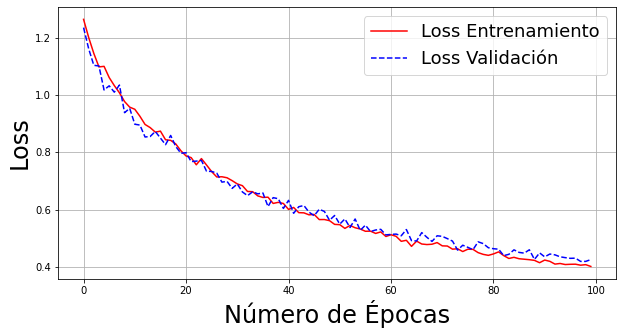

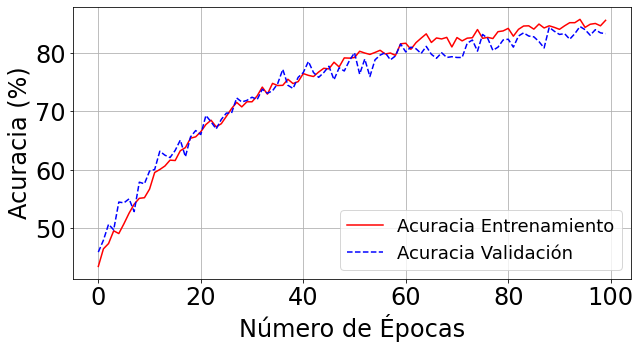

In [ ]:
plotTraining(model_history,epochs,"loss")
plotTraining(model_history,epochs,"accuracy")
plotTraining(model_history,epochs,"val_loss")
plotTraining(model_history,epochs,"val_accuracy")

In [ ]:
score=custom_vgg_model.evaluate(validation_generator,verbose=0)
print('Test loss:',score[0])
print('Test accuracy:',score[1])

Test loss: 0.424092173576355
Test accuracy: 0.8448275923728943


preds[0]: [0.06279553 0.86858475 0.0686197 ]
TOMATE SANO 86.85847520828247 %


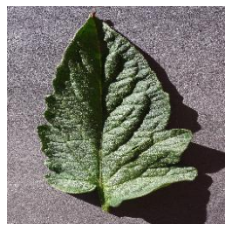

In [ ]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model

names = ['TOMATE MANCHA BACTERIANA','TOMATE SANO','TOMATE TIZON TEMPRAMO']

modelt = load_model("../content/drive/MyDrive/modelo/model_VGG16.h5")

imaget_path = "tomateSano10.JPG"
imaget=cv2.resize(cv2.imread(imaget_path), (width_shape, height_shape), interpolation = cv2.INTER_AREA)
xt = np.asarray(imaget)
xt=preprocess_input(xt)
xt = np.expand_dims(xt,axis=0)
preds = modelt.predict(xt)

print('preds[0]:',preds[0])   # ... tiene las probabilidades por cada clase ...
print(names[np.argmax(preds)],preds[0][np.argmax(preds)]*100.0,'%')
plt.imshow(cv2.cvtColor(np.asarray(imaget),cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:
import cv2
print(cv2.__version__)

4.1.2
